Thursday, June 8, 2023

I was running this in the conda environment nlpwt, but then realized it does not have the gpu version of PyTorch ... wtf!?

I am now running this in docker container sad_nightingale.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
torch.__version__

'1.13.1'

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
delimiter = '.'

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[delimiter] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Since we have a GPU, let's use it, shall we ... 

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")  # Fallback to CPU if GPU is not available
device

device(type='cuda')

In [8]:
# override the above ... cuz I want to test something ...
device = torch.device("cpu")  

In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
manualSeed = 2147483647

In [11]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden,                        generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g).to(device)
b2 = torch.randn(vocab_size,                      generator=g).to(device)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [12]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # 1) Forward Pass
    # embed the characters into vectors
    emb = C[Xb]
    # concatenate the vectors
    embcat = emb.view(emb.shape[0], -1)
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1
    # hidden layer
    h = torch.tanh(hpreact)
    # output layer
    logits = h @ W2 + b2
    # loss function
    loss = F.cross_entropy(logits, Yb)
    
    # 2) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3) update
    # step learning rate decay
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # 4) track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    
# back to the conda nlpwt environment ...
# CPU times: user 8min 24s, sys: 7.84 s, total: 8min 32s
# Wall time: 1min 6s
    
# docker container start sad_nightingale
# No .todevice(device) code
# CPU times: user 9min 24s, sys: 1.2 s, total: 9min 26s
# Wall time: 1min 13s
    
# docker container start sad_nightingale
# This is where we set device to cpu ... device = torch.device("cpu")
# CPU times: user 9min 37s, sys: 1.22 s, total: 9min 38s
# Wall time: 1min 15s
      
# docker container start sad_nightingale
# This is back to adding .to(device) ... where device is cuda.
# CPU times: user 1min 40s, sys: 1.82 s, total: 1min 42s
# Wall time: 1min 53s
    
# docker container start sad_nightingale
# This shows the time after I removed all those .to(device) statements.
# CPU times: user 9min 32s, sys: 1.03 s, total: 9min 33s
# Wall time: 1min 14s
 
# docker container start sad_nightingale    
# Why is this now slower on the GPU?!   
# This is the time when I specify .to(device) when creating each tensor.
# CPU times: user 1min 44s, sys: 1.26 s, total: 1min 45s
# Wall time: 1min 56s
    
# docker container start sad_nightingale
# CPU times: user 9min 18s, sys: 1.04 s, total: 9min 19s
# Wall time: 1min 12s
    
# running on all 8 cpus ... conda nlpwt
# CPU times: user 6min 42s, sys: 5.67 s, total: 6min 48s
# Wall time: 51.6 s
    

      0/ 200000: 27.8817
  10000/ 200000: 2.8331
  20000/ 200000: 2.4988
  30000/ 200000: 2.6304
  40000/ 200000: 2.0544
  50000/ 200000: 2.4894
  60000/ 200000: 2.4372
  70000/ 200000: 2.1040
  80000/ 200000: 2.3070
  90000/ 200000: 2.1245
 100000/ 200000: 1.9729
 110000/ 200000: 2.5353
 120000/ 200000: 2.1414
 130000/ 200000: 2.5304
 140000/ 200000: 2.3557
 150000/ 200000: 2.2075
 160000/ 200000: 2.3027
 170000/ 200000: 1.8006
 180000/ 200000: 2.3113
 190000/ 200000: 2.0539
CPU times: user 7min 51s, sys: 1.7 s, total: 7min 53s
Wall time: 1min


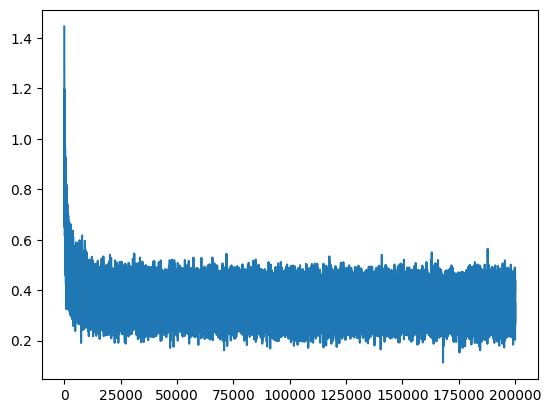

In [13]:
plt.plot(lossi)

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = { 'train' : [Xtr, Ytr],
             'val' : [Xdev, Ydev],
             'test' : [Xte, Yte]
           }[split]
    # (N, block_size, n_embed)
    emb = C[x]
    # concat into a (N, block_size * n_embed)
    embcat = emb.view(emb.shape[0], -1)
    # (N, n_hidden)
    h = torch.tanh(embcat @ W1 + b1)
    # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [15]:
split_loss('train')

train 2.2306289672851562


In [16]:
split_loss('val')

val 2.2506215572357178


In [17]:
# sample from the model
g = torch.Generator().manual_seed(manualSeed + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        ttc = torch.tensor([context]).to(device)
        emb = C[ttc] # (1, block_size, n_embed)
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1).to(device)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g) # this blows up here if we use the gpu ... !
        ix = ix.item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    # decode and print the generated word
    print(''.join(itos[i] for i in out))
        

carlah.
amorilli.
kemri.
rehty.
sacessaeja.
huen.
amerync.
kaqui.
nellara.
chaiir.
kaleig.
dham.
jorn.
quinn.
srockon.
jadii.
wazelo.
dearynixfiaun.
durabee.
deai.
